# Bank Account Fraud

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
pd.set_option('display.max_columns', 200)

In [2]:
df = pd.read_csv("Base.csv")

In [3]:
new_df = df.copy()

# Feature Encoding

In [4]:
categorical_features = [x for x in new_df.columns if new_df[x].dtypes == "O"]
categorical_features

['payment_type', 'employment_status', 'housing_status', 'source', 'device_os']

In [5]:
numeric_features = [x for x in new_df.columns if new_df[x].dtypes != "O" and new_df[x].nunique() > 2]
numeric_features

['income',
 'name_email_similarity',
 'prev_address_months_count',
 'current_address_months_count',
 'customer_age',
 'days_since_request',
 'intended_balcon_amount',
 'zip_count_4w',
 'velocity_6h',
 'velocity_24h',
 'velocity_4w',
 'bank_branch_count_8w',
 'date_of_birth_distinct_emails_4w',
 'credit_risk_score',
 'bank_months_count',
 'proposed_credit_limit',
 'session_length_in_minutes',
 'device_distinct_emails_8w',
 'month']

In [6]:
new_df = pd.DataFrame(pd.get_dummies(new_df, prefix=categorical_features))

In [7]:
new_df.head()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,credit_risk_score,email_is_free,phone_home_valid,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,session_length_in_minutes,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month,payment_type_AA,payment_type_AB,payment_type_AC,payment_type_AD,payment_type_AE,employment_status_CA,employment_status_CB,employment_status_CC,employment_status_CD,employment_status_CE,employment_status_CF,employment_status_CG,housing_status_BA,housing_status_BB,housing_status_BC,housing_status_BD,housing_status_BE,housing_status_BF,housing_status_BG,source_INTERNET,source_TELEAPP,device_os_linux,device_os_macintosh,device_os_other,device_os_windows,device_os_x11
0,1,0.9,0.166828,-1,88,50,0.020925,-1.331345,769,10650.765523,3134.319630,3863.647740,1,6,185,0,1,0,24,0,500.0,0,3.888115,0,1,0,7,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0
1,1,0.9,0.296286,-1,144,50,0.005418,-0.816224,366,534.047319,2670.918292,3124.298166,718,3,259,1,0,0,15,0,1500.0,0,31.798819,0,1,0,7,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0
2,1,0.9,0.044985,-1,132,40,3.108549,-0.755728,870,4048.534263,2893.621498,3159.590679,1,14,177,1,0,1,-1,0,200.0,0,4.728705,0,1,0,7,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0
3,1,0.9,0.159511,-1,22,50,0.019079,-1.205124,810,3457.064063,4054.908412,3022.261812,1921,6,110,1,0,1,31,1,200.0,0,2.047904,0,1,0,7,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0
4,1,0.9,0.596414,-1,218,50,0.004441,-0.773276,890,5020.341679,2728.237159,3087.670952,1990,2,295,1,1,0,31,0,1500.0,0,3.775225,1,1,0,7,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0


# Resampling

In [9]:
from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTENC

In [10]:
from collections import Counter

In [8]:
X = new_df.drop(['fraud_bool', 'device_fraud_count'], axis=1)
y = new_df['fraud_bool']

In [11]:
%%time

# NearMiss Undersampling
print(f'Test dataset samples per class {Counter(y)}')

nm = NearMiss(sampling_strategy=0.1, n_jobs=-1)
X_nm, y_nm = nm.fit_resample(X, y)

print('Resampled dataset shape %s' % Counter(y_nm))

Test dataset samples per class Counter({0: 988971, 1: 11029})
Resampled dataset shape Counter({0: 110290, 1: 11029})
Wall time: 6min 40s


In [12]:
from sklearn.metrics import classification_report, confusion_matrix, auc, roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold

In [13]:
X_train,X_test,y_train,y_test = train_test_split(X_nm, y_nm, test_size=0.25, random_state=42, stratify=y_nm)

# Feature Scaling

In [14]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler

In [15]:
numeric_transformer = MinMaxScaler()

preprocessor = ColumnTransformer(transformers=[('numeric_transformer', numeric_transformer, numeric_features)], remainder='passthrough')

X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)

In [16]:
X_train_scaled = pd.DataFrame(X_train_scaled)
X_test_scaled = pd.DataFrame(X_test_scaled)

# Train Classifier

In [17]:
# https://stackoverflow.com/questions/48370150/how-to-implement-smote-in-cross-validation-and-gridsearchcv
# https://stackoverflow.com/questions/69388476/pipeline-and-gridsearch-pipeline-fully-recomputed

def train_classifier(classifier, param_dist, X_train, y_train, encoded_features):
    
    smote_nc = SMOTENC(categorical_features=encoded_features, sampling_strategy='minority', random_state=42)
        
    pipeline = make_pipeline(smote_nc, classifier)
    
    cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
    
    rand_search = RandomizedSearchCV(estimator=pipeline, 
                                      param_distributions=param_dist,
                                      n_iter=10,
                                      scoring="roc_auc",
                                      n_jobs=-1,
                                      cv=cv)

    rand_search.fit(X_train, y_train)
    
    return rand_search

# Test Classifier

In [18]:
def plot_roc_curve(fpr, tpr):
    
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 6))
    
    plt.plot(fpr, tpr, label=f'AUC={roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [19]:
def cls_report(y_pred, y_pred_threshold):

    report1 = classification_report(y_test, y_pred, target_names=['No Fraud', 'Fraud'])
    report2 = classification_report(y_test, y_pred_threshold, target_names=['No Fraud', 'Fraud'])

    print('Default Threshold:')
    print('*****' * 10)
    print(report1)
    print('Target Threshold:')
    print('*****' * 10)
    print(report2)

In [20]:
def plot_con_matrix(ax, y_test, y_pred, title):

    classes = ['No Fraud', 'Fraud']
    con_matrix = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = con_matrix.ravel()
    fpr = fp / (fp + tn)

    ax.imshow(con_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(classes)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(classes)

    fmt = 'd'
    threshold = con_matrix.max() / 2.
    for i, j in np.ndindex(con_matrix.shape):
        ax.text(j, i, format(con_matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if con_matrix[i, j] > threshold else "black")

    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    ax.set_title(f'{title} with {fpr*100:.2f}% FPR')

In [21]:
def test_classifier(classifier, X_test, y_test):
    
    y_pred = classifier.predict(X_test)
    y_prob = classifier.predict_proba(X_test)[:, 1]

    # Calculate the false positive rate and true positive rate for different threshold values
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)

    # Plot the ROC curve
    plot_roc_curve(fpr, tpr)

    # Choose a false positive rate threshold based on the ROC curve
    target_fpr = 0.05
    threshold_idx = np.argmin(np.abs(fpr - target_fpr))
    threshold = thresholds[threshold_idx]
    
    # Make predictions on the testing set using the threshold
    y_pred_threshold = (y_prob >= threshold).astype(int)
    
    # Print the classification report
    cls_report(y_pred, y_pred_threshold)

    # Plot confusion matrix
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    plot_con_matrix(ax1, y_test, y_pred, title='Default Threshold @ 0.50')
    plot_con_matrix(ax2, y_test, y_pred_threshold, title=f'Target Threshold @ {threshold:.2f}')

    plt.tight_layout()
    plt.show()

# Logistic Regression

In [22]:
encoded_scaled_features = [feature for feature in X_train_scaled.columns if X_train_scaled[feature].nunique() == 2] # for scaled numerics
encoded_scaled_features

[19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50]

In [25]:
# Logistic Regression

from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()

lr_params = {'logisticregression__C': [0.01, 0.1, 1, 10, 100, 1000],
             'logisticregression__solver': ['lbfgs', 'liblinear', 'newton-cg', 'sag'],
             'logisticregression__max_iter': [1000, 2500, 5000]
            }

In [26]:
%%time

lr_model = train_classifier(lr, lr_params, X_train_scaled, y_train, encoded_scaled_features)

Wall time: 9min 42s


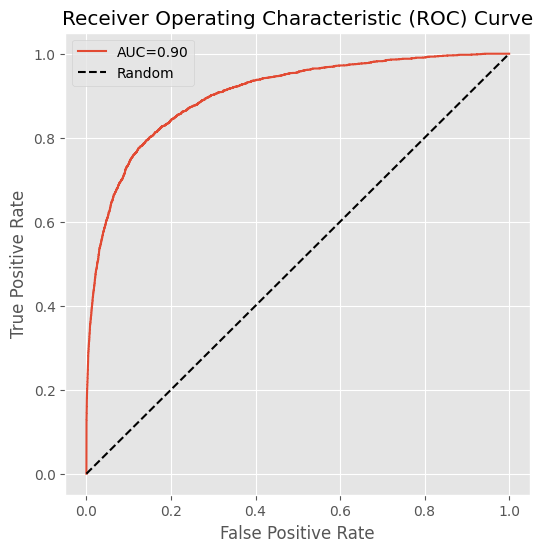

Default Threshold:
**************************************************
              precision    recall  f1-score   support

    No Fraud       0.96      0.94      0.95     27573
       Fraud       0.51      0.65      0.57      2757

    accuracy                           0.91     30330
   macro avg       0.74      0.80      0.76     30330
weighted avg       0.92      0.91      0.92     30330

Target Threshold:
**************************************************
              precision    recall  f1-score   support

    No Fraud       0.96      0.95      0.96     27573
       Fraud       0.55      0.61      0.58      2757

    accuracy                           0.92     30330
   macro avg       0.75      0.78      0.77     30330
weighted avg       0.92      0.92      0.92     30330



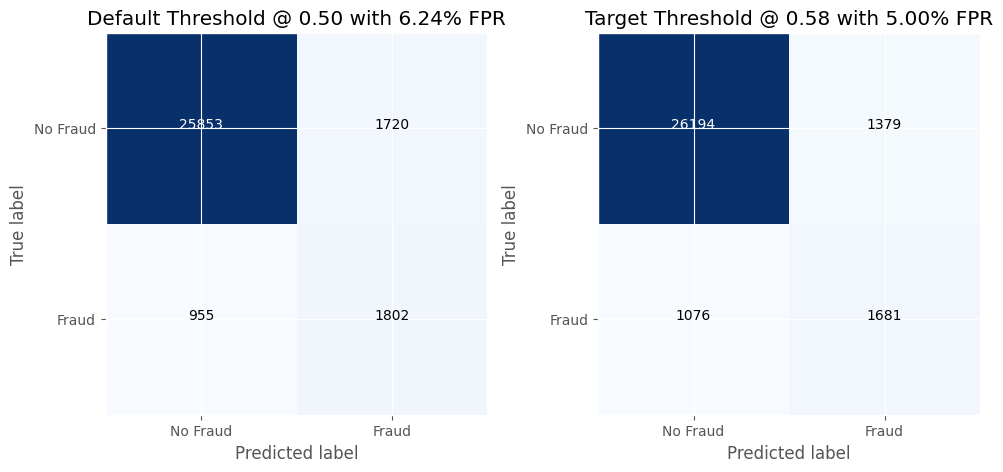

In [27]:
test_classifier(lr_model, X_test_scaled, y_test)

# Decision Tree

In [28]:
encoded_unscaled_features = [X_train.columns.get_loc(str(feature)) for feature in X_train.columns if X_train[feature].nunique() == 2] # for unscaled numerics
encoded_unscaled_features

[14,
 15,
 16,
 18,
 20,
 22,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50]

In [29]:
# Decision Tree Classifier

from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()

dt_params = {'decisiontreeclassifier__criterion': ['gini', 'entropy'],
             'decisiontreeclassifier__max_depth': [2, 4, 6, 8, 10],
             'decisiontreeclassifier__max_features': ['sqrt', 'log2']
            }

In [30]:
%%time

dt_model = train_classifier(dt, dt_params, X_train, y_train, encoded_unscaled_features)

Wall time: 8min 49s


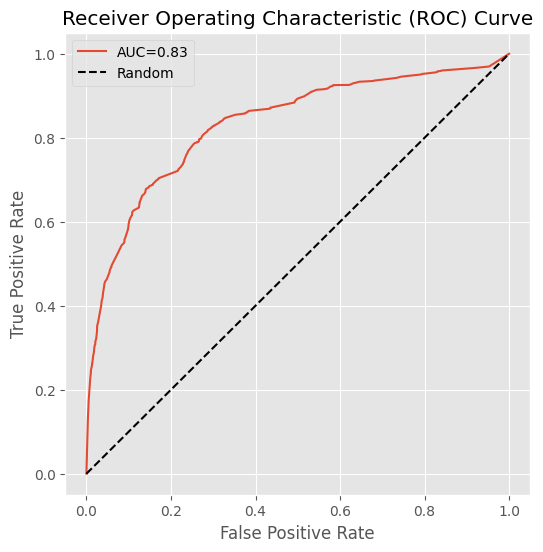

Default Threshold:
**************************************************
              precision    recall  f1-score   support

    No Fraud       0.96      0.86      0.91     27573
       Fraud       0.32      0.67      0.44      2757

    accuracy                           0.84     30330
   macro avg       0.64      0.77      0.67     30330
weighted avg       0.91      0.84      0.87     30330

Target Threshold:
**************************************************
              precision    recall  f1-score   support

    No Fraud       0.95      0.95      0.95     27573
       Fraud       0.49      0.46      0.48      2757

    accuracy                           0.91     30330
   macro avg       0.72      0.71      0.71     30330
weighted avg       0.91      0.91      0.91     30330



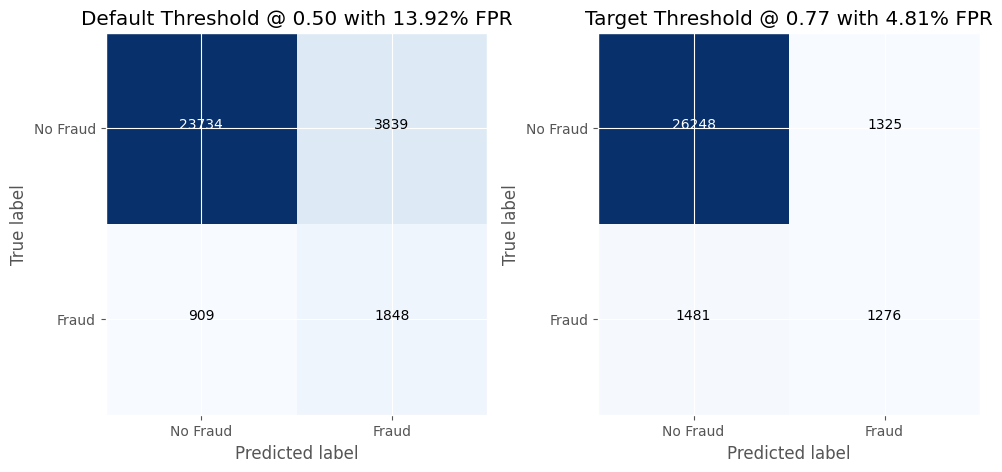

In [31]:
test_classifier(dt_model, X_test, y_test)

# Random Forest

In [32]:
# RandomForest

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()

rf_params = {'randomforestclassifier__n_estimators': [20, 40, 60, 80, 100],
            'randomforestclassifier__criterion': ['gini', 'entropy'],
            'randomforestclassifier__max_depth': [2, 4, 6, 8, 10],
            'randomforestclassifier__max_features': ['sqrt', 'log2']
            }

In [33]:
%%time

rf_model = train_classifier(rf, rf_params, X_train, y_train, encoded_unscaled_features)

Wall time: 10min 20s


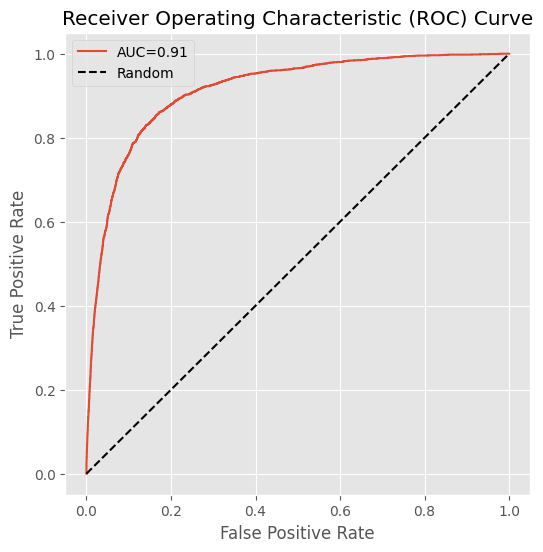

Default Threshold:
**************************************************
              precision    recall  f1-score   support

    No Fraud       0.97      0.93      0.95     27573
       Fraud       0.50      0.69      0.58      2757

    accuracy                           0.91     30330
   macro avg       0.73      0.81      0.76     30330
weighted avg       0.92      0.91      0.92     30330

Target Threshold:
**************************************************
              precision    recall  f1-score   support

    No Fraud       0.96      0.95      0.96     27573
       Fraud       0.55      0.61      0.58      2757

    accuracy                           0.92     30330
   macro avg       0.75      0.78      0.77     30330
weighted avg       0.92      0.92      0.92     30330



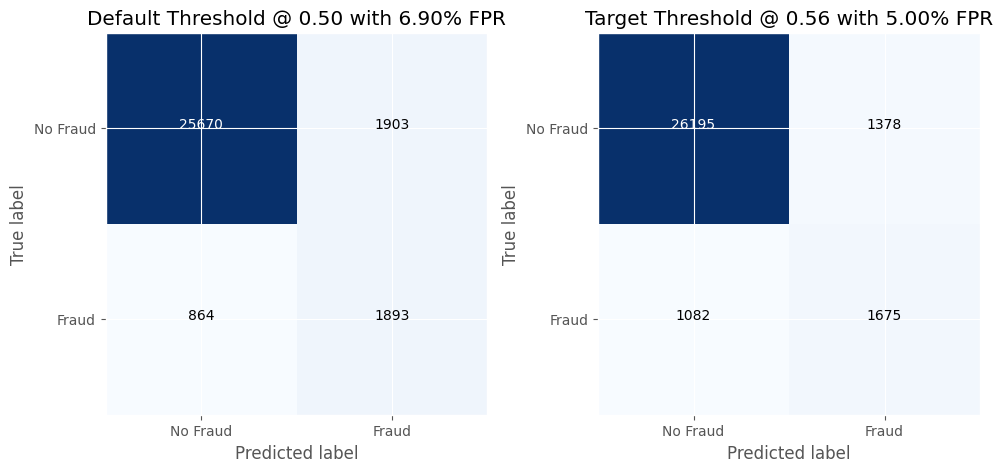

In [34]:
test_classifier(rf_model, X_test, y_test)

# XGBoost

In [38]:
# XGBoost

from xgboost import XGBClassifier

xgb = XGBClassifier(tree_method='gpu_hist')

xgb_params = {'xgbclassifier__n_estimators': [20, 40, 60, 80, 100],
              'xgbclassifier__max_depth': [2, 4, 6, 8, 10],
              'xgbclassifier__learning_rate': [0.05, 0.1, 0.15, 0.20],
              'xgbclassifier__min_child_weight': [1, 2, 3, 4],
              'xgbclassifier__subsample': [0.6, 0.8, 1.0],
              'xgbclassifier__colsample_bytree': [0.6, 0.8, 1.0]
             }

In [39]:
%%time

xgb_model = train_classifier(xgb, xgb_params, X_train, y_train, encoded_unscaled_features)

Wall time: 5min 42s


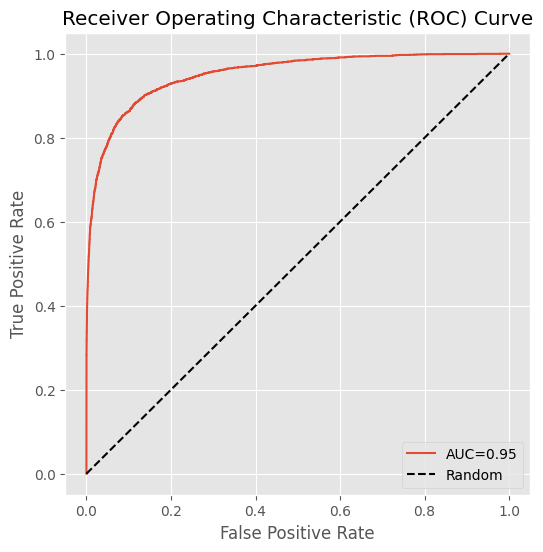

Default Threshold:
**************************************************
              precision    recall  f1-score   support

    No Fraud       0.97      0.98      0.97     27573
       Fraud       0.80      0.65      0.72      2757

    accuracy                           0.95     30330
   macro avg       0.88      0.82      0.84     30330
weighted avg       0.95      0.95      0.95     30330

Target Threshold:
**************************************************
              precision    recall  f1-score   support

    No Fraud       0.98      0.95      0.96     27573
       Fraud       0.61      0.79      0.69      2757

    accuracy                           0.93     30330
   macro avg       0.79      0.87      0.83     30330
weighted avg       0.94      0.93      0.94     30330



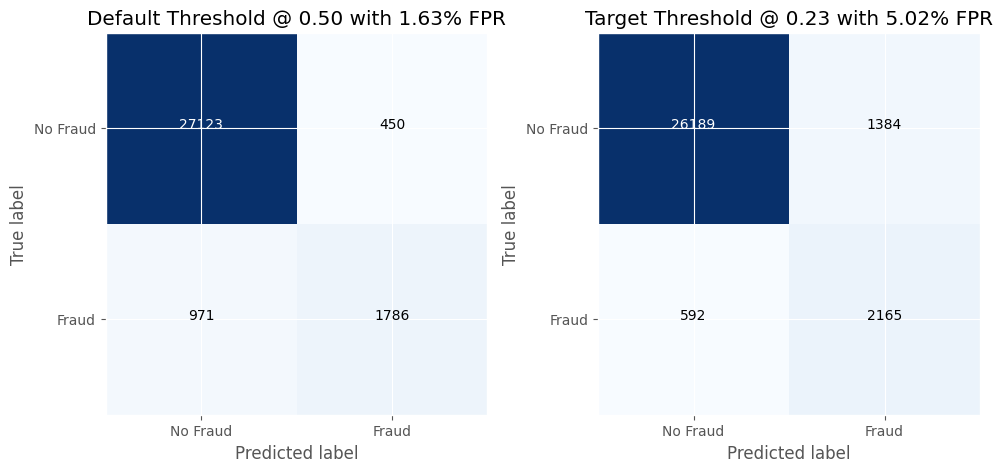

In [40]:
test_classifier(xgb_model, X_test, y_test)

# LightGBM

In [41]:
# LightGBM

from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(device='gpu')

lgbm_params = {'lgbmclassifier__max_depth': [2, 4, 6, 8, 10],
               'lgbmclassifier__learning_rate': [0.05, 0.1, 0.15, 0.20],
               'lgbmclassifier__n_estimators': [20, 40, 60, 80, 100],
               'lgbmclassifier__min_child_weight': [1, 2, 3, 4],
               'lgbmclassifier__subsample': [0.6, 0.8, 1.0],
               'lgbmclassifier__colsample_bytree': [0.6, 0.8, 1.0]
              }

In [42]:
%%time

lgbm_model = train_classifier(lgbm, lgbm_params, X_train, y_train, encoded_unscaled_features)

c:\Users\Matthew McNulty\Development\bank-account-fraud\venv\lib\site-packages\joblib\externals\loky\process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Wall time: 6min 17s


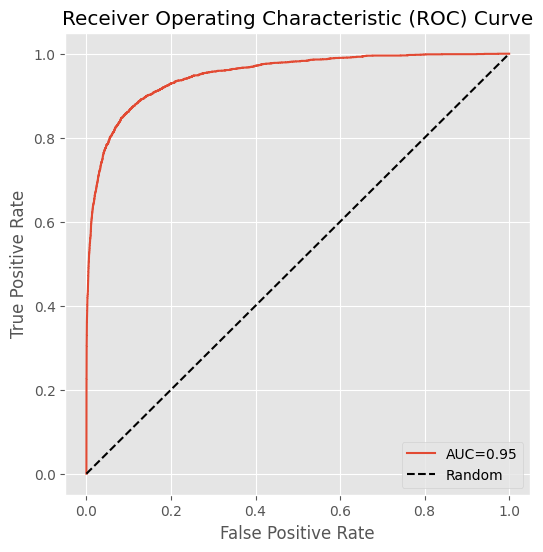

Default Threshold:
**************************************************
              precision    recall  f1-score   support

    No Fraud       0.97      0.98      0.97     27573
       Fraud       0.79      0.64      0.71      2757

    accuracy                           0.95     30330
   macro avg       0.88      0.81      0.84     30330
weighted avg       0.95      0.95      0.95     30330

Target Threshold:
**************************************************
              precision    recall  f1-score   support

    No Fraud       0.98      0.95      0.96     27573
       Fraud       0.61      0.78      0.69      2757

    accuracy                           0.94     30330
   macro avg       0.79      0.87      0.83     30330
weighted avg       0.94      0.94      0.94     30330



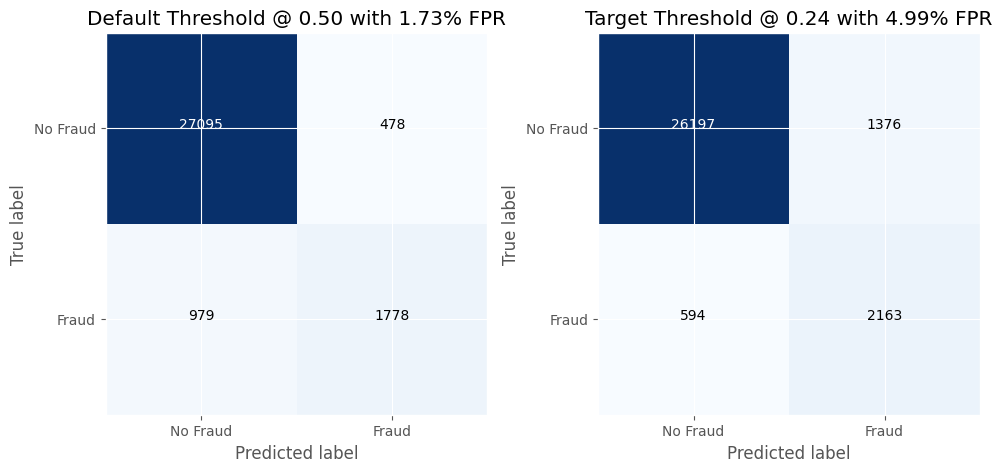

In [43]:
test_classifier(lgbm_model, X_test, y_test)